# Traditional Machine Learning for BBC News Text Classification

## Table of Contents
1. [Setup & Imports](#setup)
2. [Data Loading & Exploration](#data)
3. [Data Preprocessing](#preprocessing)
4. [Feature Extraction - TF-IDF](#tfidf)
5. [Feature Extraction - GloVe](#glove)
6. [Feature Extraction - FastText](#fasttext)
7. [Model Training - Random Forest](#random-forest)
8. [Model Training - SVM](#svm)
9. [Results Comparison](#comparison)
10. [Conclusion](#conclusion)

In [1]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# Gensim for FastText
from gensim.models import FastText
from gensim.utils import simple_preprocess

# Joblib for model saving
import joblib

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Download NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True


## 2. Data Loading & Exploration <a id='data'></a>

In [3]:
# Define data path
DATA_DIR = Path('../data/bbc')
CATEGORIES = ['business', 'entertainment', 'politics', 'sport', 'tech']

print(f"Data directory: {DATA_DIR}")
print(f"Categories: {CATEGORIES}")

Data directory: ..\data\bbc
Categories: ['business', 'entertainment', 'politics', 'sport', 'tech']


In [4]:
# Load dataset
def load_bbc_dataset(data_dir, categories):
   
    documents = []
    labels = []
    
    for category in categories:
        category_path = data_dir / category
        if not category_path.exists():
            print(f"Warning: Category folder '{category}' not found")
            continue
        
        # Read all .txt files in category
        for file_path in category_path.glob('*.txt'):
            try:
                with open(file_path, 'r', encoding='latin-1') as f:
                    text = f.read()
                    documents.append(text)
                    labels.append(category)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    
    df = pd.DataFrame({
        'text': documents,
        'category': labels
    })
    
    return df

# Load data
df = load_bbc_dataset(DATA_DIR, CATEGORIES)
print(f"\nDataset loaded successfully!")
print(f"Total documents: {len(df)}")
print(f"\nDataset shape: {df.shape}")


Dataset loaded successfully!
Total documents: 2225

Dataset shape: (2225, 2)


In [5]:
# Display first few rows
print("First 3 documents:")
df.head(3)

First 3 documents:


,text,category
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business


In [6]:
# Dataset statistics
print("Dataset Information:")
print(df.info())
print("\n" + "="*50)
print("\nCategory Distribution:")
print(df['category'].value_counts())
print("\n" + "="*50)
print("\nCategory Percentages:")
print(df['category'].value_counts(normalize=True) * 100)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      2225 non-null   object
 1   category  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB
None


Category Distribution:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


Category Percentages:
category
sport            22.966292
business         22.921348
politics         18.741573
tech             18.022472
entertainment    17.348315
Name: proportion, dtype: float64


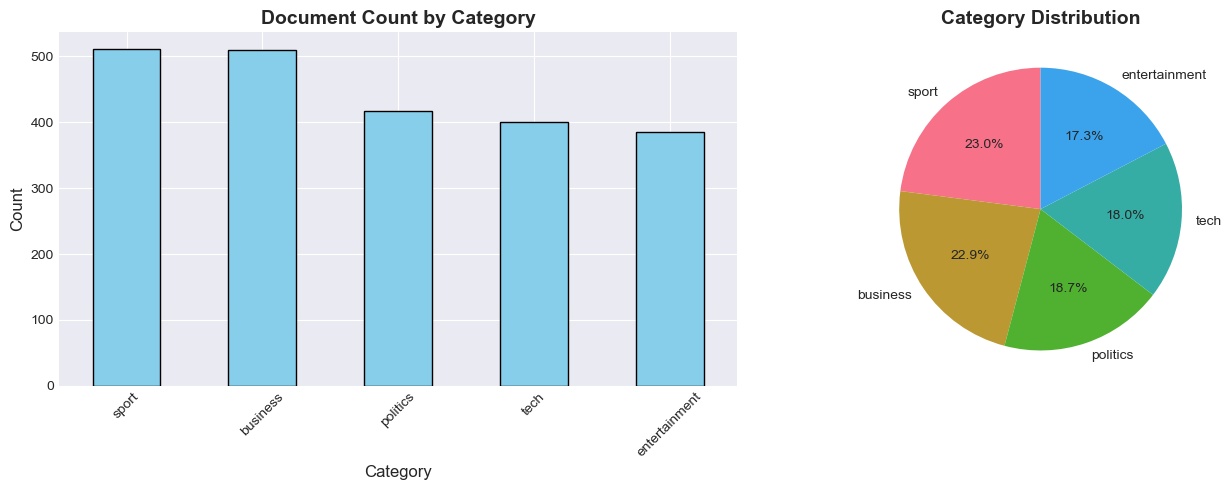

In [7]:
# Visualize category distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
df['category'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Document Count by Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
df['category'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Category Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('results/category_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Text length analysis
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

print("Text Length Statistics:")
print(df[['text_length', 'word_count']].describe())

Text Length Statistics:
        text_length   word_count
count   2225.000000  2225.000000
mean    2265.791011   384.040449
std     1364.306078   238.174497
min      503.000000    89.000000
25%     1448.000000   246.000000
50%     1967.000000   332.000000
75%     2804.000000   471.000000
max    25485.000000  4432.000000


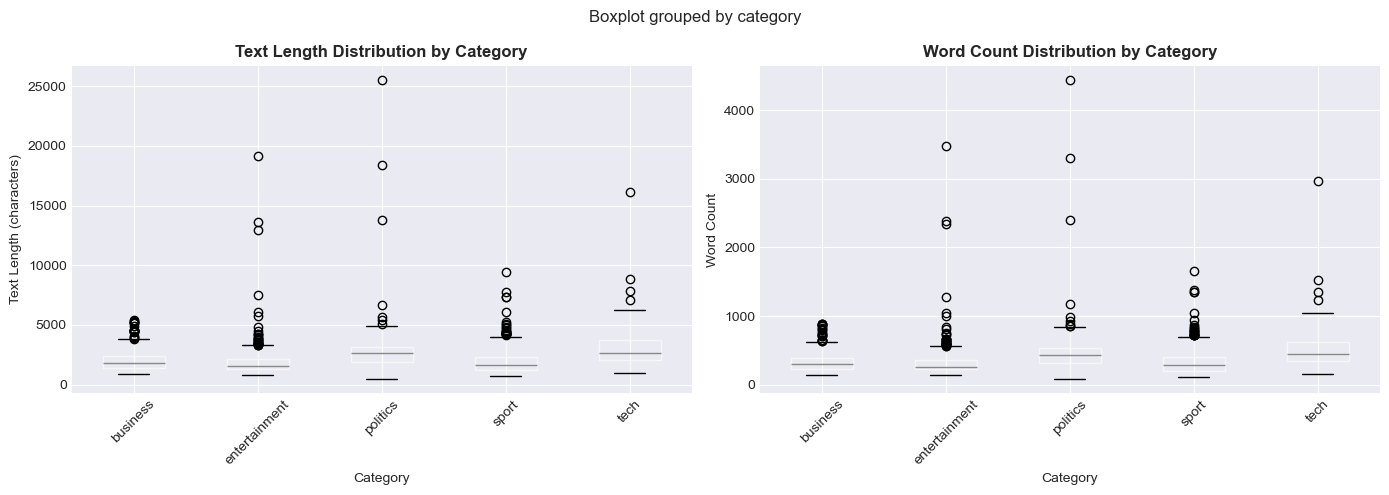

In [9]:
# Visualize text length by category
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df.boxplot(column='text_length', by='category', ax=axes[0])
axes[0].set_title('Text Length Distribution by Category', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Category', fontsize=10)
axes[0].set_ylabel('Text Length (characters)', fontsize=10)
plt.sca(axes[0])
plt.xticks(rotation=45)

df.boxplot(column='word_count', by='category', ax=axes[1])
axes[1].set_title('Word Count Distribution by Category', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Category', fontsize=10)
axes[1].set_ylabel('Word Count', fontsize=10)
plt.sca(axes[1])
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('results/text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. Data Preprocessing <a id='preprocessing'></a>

In [10]:
# Text preprocessing function
def preprocess_text(text, remove_stopwords=True, lemmatize=True):
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Remove short words (length < 3)
    tokens = [word for word in tokens if len(word) >= 3]
    
    return ' '.join(tokens)

print("Example preprocessing:")
sample_text = df['text'].iloc[0][:200]
print(f"Original: {sample_text}")
print(f"\nPreprocessed: {preprocess_text(sample_text)}")

Example preprocessing:
Original: Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one 

Preprocessed: sale boost time warner profit quarterly profit medium giant timewarner jumped three month december yearearlier firm one


In [11]:
# Apply preprocessing to all documents
print("Preprocessing all documents...")
df['processed_text'] = df['text'].apply(preprocess_text)
print("Preprocessing complete!")

# Display samples
df[['category', 'processed_text']].head(3)

Preprocessing all documents...
Preprocessing complete!


,category,processed_text
0,business,sale boost time warner profit quarterly profit...
1,business,dollar gain greenspan speech dollar hit highes...
2,business,yukos unit buyer face loan claim owner embattl...


In [12]:
# Split data into train, validation, and test sets
X = df['processed_text']
y = df['category']

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 75% train, 25% val (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTrain distribution:\n{y_train.value_counts()}")
print(f"\nValidation distribution:\n{y_val.value_counts()}")
print(f"\nTest distribution:\n{y_test.value_counts()}")

Training set size: 1335
Validation set size: 445
Test set size: 445

Train distribution:
category
sport            307
business         306
politics         250
tech             240
entertainment    232
Name: count, dtype: int64

Validation distribution:
category
business         102
sport            102
politics          83
tech              81
entertainment     77
Name: count, dtype: int64

Test distribution:
category
business         102
sport            102
politics          84
tech              80
entertainment     77
Name: count, dtype: int64


## 4. Feature Extraction - TF-IDF <a id='tfidf'></a>

**TF-IDF (Term Frequency-Inverse Document Frequency)** is a numerical statistic that reflects how important a word is to a document in a collection.

In [13]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Keep top 5000 features
    min_df=2,           # Ignore terms that appear in less than 2 documents
    max_df=0.8,         # Ignore terms that appear in more than 80% of documents
    ngram_range=(1, 2)  # Use unigrams and bigrams
)

# Fit and transform
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF features created!")
print(f"Feature shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

TF-IDF features created!
Feature shape: (1335, 5000)
Vocabulary size: 5000


In [14]:
# Show top TF-IDF terms per category
def get_top_tfidf_terms(vectorizer, X, y, category, n=10):
    
    # Filter documents by category
    mask = y == category
    X_category = X[mask]
    
    # Sum TF-IDF scores
    tfidf_sum = np.array(X_category.sum(axis=0)).flatten()
    
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    
    # Get top indices
    top_indices = tfidf_sum.argsort()[-n:][::-1]
    
    return [(feature_names[i], tfidf_sum[i]) for i in top_indices]

print("Top 10 TF-IDF terms per category:\n")
for category in CATEGORIES:
    top_terms = get_top_tfidf_terms(tfidf_vectorizer, X_train_tfidf, y_train.values, category)
    print(f"\n{category.upper()}:")
    for term, score in top_terms:
        print(f"  {term}: {score:.2f}")

Top 10 TF-IDF terms per category:


BUSINESS:
  bank: 12.25
  company: 11.89
  economy: 11.09
  growth: 10.94
  year: 10.65
  firm: 10.36
  share: 10.21
  sale: 10.09
  market: 9.77
  price: 9.41

ENTERTAINMENT:
  film: 19.89
  award: 13.35
  music: 9.54
  show: 9.25
  best: 9.22
  star: 8.19
  band: 7.83
  year: 7.11
  album: 6.81
  oscar: 6.72

POLITICS:
  labour: 15.64
  blair: 15.58
  election: 14.68
  party: 14.15
  government: 11.51
  tory: 11.30
  would: 11.27
  minister: 10.91
  brown: 9.88
  lord: 8.41

SPORT:
  game: 14.21
  england: 11.34
  player: 11.30
  win: 10.49
  injury: 9.25
  cup: 8.67
  match: 8.51
  club: 7.99
  team: 7.90
  ireland: 7.84

TECH:
  game: 11.80
  people: 10.69
  mobile: 10.04
  technology: 9.97
  phone: 9.57
  user: 9.22
  software: 8.90
  computer: 8.25
  net: 7.66
  site: 7.21



## 5. Feature Extraction - GloVe <a id='glove'></a>

**GloVe (Global Vectors)** creates word embeddings by aggregating global word-word co-occurrence statistics.

In [15]:

GLOVE_PATH = '../models/glove.6B.100d.txt'  # Update this path

def load_glove_embeddings(glove_path):
    
    embeddings = {}
    
    if not os.path.exists(glove_path):
        print(f"WARNING: GloVe file not found at {glove_path}")
        print("Please download from: https://nlp.stanford.edu/projects/glove/")
        print("Recommended: glove.6B.zip (glove.6B.100d.txt)")
        return None
    
    print("Loading GloVe embeddings...")
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    
    print(f"Loaded {len(embeddings)} word vectors")
    print(f"Vector dimension: {len(next(iter(embeddings.values())))}")
    return embeddings

# Load GloVe
glove_embeddings = load_glove_embeddings(GLOVE_PATH)

Please download from: https://nlp.stanford.edu/projects/glove/
Recommended: glove.6B.zip (glove.6B.100d.txt)


In [16]:
# Create document embeddings by averaging word vectors
def get_doc_embedding_glove(text, embeddings, embedding_dim=100):
   
    if embeddings is None:
        return np.zeros(embedding_dim)
    
    words = text.split()
    word_vectors = [embeddings[word] for word in words if word in embeddings]
    
    if len(word_vectors) == 0:
        return np.zeros(embedding_dim)
    
    return np.mean(word_vectors, axis=0)

if glove_embeddings is not None:
    print("Creating document embeddings with GloVe...")
    X_train_glove = np.array([get_doc_embedding_glove(text, glove_embeddings) for text in X_train])
    X_val_glove = np.array([get_doc_embedding_glove(text, glove_embeddings) for text in X_val])
    X_test_glove = np.array([get_doc_embedding_glove(text, glove_embeddings) for text in X_test])
    
    print(f"GloVe embeddings created!")
    print(f"Feature shape: {X_train_glove.shape}")
else:
    print("WARNING: Skipping GloVe embeddings - file not found")
    X_train_glove = X_val_glove = X_test_glove = None


## 6. Feature Extraction - FastText <a id='fasttext'></a>

**FastText** learns word embeddings using neural networks and subword information, making it robust to rare words and typos.

In [17]:
# Tokenize for FastText training
tokenized_docs = [simple_preprocess(doc) for doc in X_train]
tokenized_val = [simple_preprocess(doc) for doc in X_val]

# Hyperparameters
HYPERPARAMETERS = {
    'vector_size': 100,
    'window': 5,
    'min_count': 2,
    'workers': 4,
    'sg': 0,  # 0=CBOW, 1=Skip-gram
    'epochs': 30,
    'min_n': 3,
    'max_n': 6,
    'learning_rate': 0.05
}

print("FastText Hyperparameters:")
print("=" * 50)
for param, value in HYPERPARAMETERS.items():
    print(f"{param:20s}: {value}")
print("=" * 50)

# Initialize FastText model
print("\nInitializing FastText model...")
fasttext_model = FastText(
    vector_size=HYPERPARAMETERS['vector_size'],
    window=HYPERPARAMETERS['window'],
    min_count=HYPERPARAMETERS['min_count'],
    workers=HYPERPARAMETERS['workers'],
    sg=HYPERPARAMETERS['sg'],
    min_n=HYPERPARAMETERS['min_n'],
    max_n=HYPERPARAMETERS['max_n'],
    alpha=HYPERPARAMETERS['learning_rate'],
    min_alpha=0.0001
)

# Build vocabulary
print("Building vocabulary...")
fasttext_model.build_vocab(tokenized_docs)
print(f"Vocabulary size: {len(fasttext_model.wv)}")

# Track metrics per epoch
print(f"\nTraining FastText model for {HYPERPARAMETERS['epochs']} epochs...")
print("Tracking metrics at each epoch...\n")

FastText Hyperparameters:
vector_size         : 100
window              : 5
min_count           : 2
workers             : 4
sg                  : 0
epochs              : 30
min_n               : 3
max_n               : 6
learning_rate       : 0.05

Initializing FastText model...
Building vocabulary...
Vocabulary size: 13288

Training FastText model for 30 epochs...
Tracking metrics at each epoch...



In [21]:
# Test FastText - find similar words
test_words = ['government', 'player', 'technology', 'company', 'film']

print("FastText - Most similar words:\n")
for word in test_words:
    if word in fasttext_model.wv:
        similar = fasttext_model.wv.most_similar(word, topn=5)
        print(f"\n{word.upper()}:")
        for sim_word, score in similar:
            print(f"  {sim_word}: {score:.3f}")
    else:
        print(f"\n{word.upper()}: Not in vocabulary")

FastText - Most similar words:


GOVERNMENT:
  governs: 0.725
  govern: 0.725
  abandonment: 0.634
  governor: 0.628
  internment: 0.589

PLAYER:
  slayer: 0.834
  multiplayer: 0.756
  playmaker: 0.624
  playoff: 0.593
  bayer: 0.546

TECHNOLOGY:
  nanotechnology: 0.960
  technological: 0.831
  tech: 0.711
  chronology: 0.685
  eulogy: 0.684

COMPANY:
  companion: 0.699
  accompanying: 0.642
  compact: 0.535
  compassion: 0.519
  comparison: 0.517

FILM:
  filmed: 0.789
  filming: 0.747
  filmmaker: 0.659
  filmmaking: 0.585
  fill: 0.567


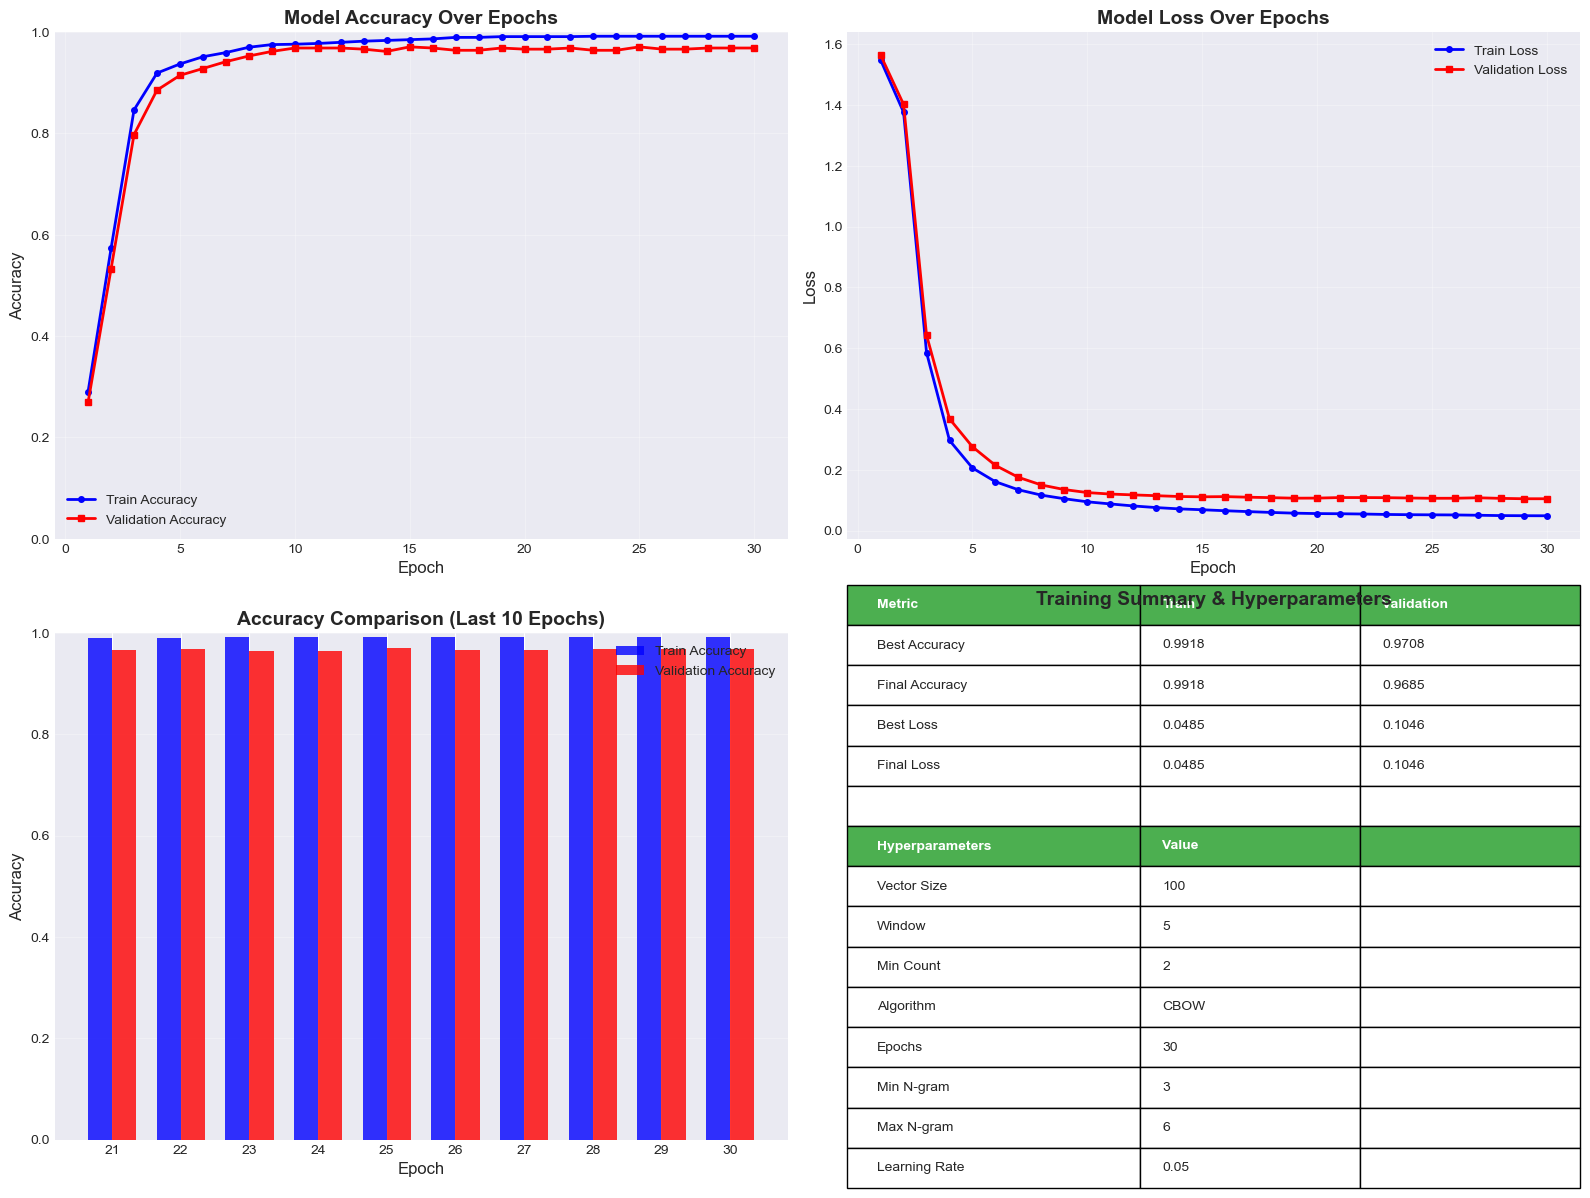


Training visualization saved to results/fasttext_training_history.png


In [20]:
# Visualize Training History
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy over epochs
ax1 = axes[0, 0]
ax1.plot(metrics_df['epoch'], metrics_df['train_accuracy'], 'b-o', label='Train Accuracy', linewidth=2, markersize=4)
ax1.plot(metrics_df['epoch'], metrics_df['val_accuracy'], 'r-s', label='Validation Accuracy', linewidth=2, markersize=4)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot 2: Loss over epochs
ax2 = axes[0, 1]
ax2.plot(metrics_df['epoch'], metrics_df['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=4)
ax2.plot(metrics_df['epoch'], metrics_df['val_loss'], 'r-s', label='Validation Loss', linewidth=2, markersize=4)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Accuracy comparison (final 10 epochs zoomed)
ax3 = axes[1, 0]
last_10 = metrics_df.tail(10)
x_pos = np.arange(len(last_10))
width = 0.35
ax3.bar(x_pos - width/2, last_10['train_accuracy'], width, label='Train Accuracy', alpha=0.8, color='blue')
ax3.bar(x_pos + width/2, last_10['val_accuracy'], width, label='Validation Accuracy', alpha=0.8, color='red')
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Accuracy', fontsize=12)
ax3.set_title('Accuracy Comparison (Last 10 Epochs)', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(last_10['epoch'].values)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim([0, 1])

# Plot 4: Metrics summary table
ax4 = axes[1, 1]
ax4.axis('off')

# Calculate summary statistics
summary_stats = [
    ['Metric', 'Train', 'Validation'],
    ['Best Accuracy', f"{max(metrics_df['train_accuracy']):.4f}", f"{max(metrics_df['val_accuracy']):.4f}"],
    ['Final Accuracy', f"{metrics_df['train_accuracy'].iloc[-1]:.4f}", f"{metrics_df['val_accuracy'].iloc[-1]:.4f}"],
    ['Best Loss', f"{min(metrics_df['train_loss']):.4f}", f"{min(metrics_df['val_loss']):.4f}"],
    ['Final Loss', f"{metrics_df['train_loss'].iloc[-1]:.4f}", f"{metrics_df['val_loss'].iloc[-1]:.4f}"],
    ['', '', ''],
    ['Hyperparameters', 'Value', ''],
    ['Vector Size', f"{HYPERPARAMETERS['vector_size']}", ''],
    ['Window', f"{HYPERPARAMETERS['window']}", ''],
    ['Min Count', f"{HYPERPARAMETERS['min_count']}", ''],
    ['Algorithm', 'CBOW' if HYPERPARAMETERS['sg']==0 else 'Skip-gram', ''],
    ['Epochs', f"{HYPERPARAMETERS['epochs']}", ''],
    ['Min N-gram', f"{HYPERPARAMETERS['min_n']}", ''],
    ['Max N-gram', f"{HYPERPARAMETERS['max_n']}", ''],
    ['Learning Rate', f"{HYPERPARAMETERS['learning_rate']}", '']
]

table = ax4.table(cellText=summary_stats, cellLoc='left', loc='center',
                  colWidths=[0.4, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header rows
for i in [0, 6]:
    for j in range(3):
        table[(i, j)].set_facecolor('#4CAF50')
        table[(i, j)].set_text_props(weight='bold', color='white')

ax4.set_title('Training Summary & Hyperparameters', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('results/fasttext_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTraining visualization saved to results/fasttext_training_history.png")

In [19]:
# Create comprehensive metrics dataframe
metrics_df = pd.DataFrame(epoch_metrics)
print("\nEpoch-wise Metrics Summary:")
print("=" * 80)
print(metrics_df.to_string(index=False))
print("=" * 80)

# Save metrics to CSV
metrics_df.to_csv('results/fasttext_training_metrics.csv', index=False)
print("\nMetrics saved to results/fasttext_training_metrics.csv")


Epoch-wise Metrics Summary:
 epoch  train_accuracy  val_accuracy  train_loss  val_loss
     1        0.290637      0.269663    1.548676  1.564787
     2        0.573034      0.532584    1.376773  1.402607
     3        0.846442      0.797753    0.585724  0.643213
     4        0.919101      0.885393    0.296654  0.367639
     5        0.937079      0.914607    0.205821  0.275513
     6        0.951311      0.928090    0.160597  0.214321
     7        0.959551      0.941573    0.134124  0.175072
     8        0.970037      0.952809    0.116472  0.149899
     9        0.975281      0.961798    0.104609  0.134794
    10        0.976030      0.968539    0.094526  0.124896
    11        0.977528      0.968539    0.087503  0.120043
    12        0.979775      0.968539    0.080894  0.117248
    13        0.982022      0.966292    0.075521  0.114634
    14        0.983521      0.961798    0.071219  0.111989
    15        0.985019      0.970787    0.068366  0.110938
    16        0.986517     

In [18]:
# Train with epoch-by-epoch tracking
from sklearn.linear_model import LogisticRegression

# Storage for metrics
epoch_metrics = {
    'epoch': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'train_loss': [],
    'val_loss': []
}

# Helper function to get embeddings
def get_embeddings(docs, model):
    embeddings = []
    for doc in docs:
        word_vectors = [model.wv[word] for word in doc if word in model.wv]
        if len(word_vectors) > 0:
            embeddings.append(np.mean(word_vectors, axis=0))
        else:
            embeddings.append(np.zeros(model.wv.vector_size))
    return np.array(embeddings)

# Train epoch by epoch
for epoch in range(1, HYPERPARAMETERS['epochs'] + 1):
    # Train for one epoch
    fasttext_model.train(
        tokenized_docs,
        total_examples=len(tokenized_docs),
        epochs=1
    )
    
    # Get embeddings
    X_train_emb = get_embeddings(tokenized_docs, fasttext_model)
    X_val_emb = get_embeddings(tokenized_val, fasttext_model)
    
    # Train a simple classifier to evaluate embeddings quality
    clf = LogisticRegression(max_iter=100, random_state=42)
    clf.fit(X_train_emb, y_train)
    
    # Calculate accuracies
    train_acc = clf.score(X_train_emb, y_train)
    val_acc = clf.score(X_val_emb, y_val)
    
    # Calculate losses (negative log likelihood approximation)
    train_proba = clf.predict_proba(X_train_emb)
    val_proba = clf.predict_proba(X_val_emb)
    
    # Get true labels as indices
    label_encoder = {label: idx for idx, label in enumerate(clf.classes_)}
    train_true_idx = [label_encoder[label] for label in y_train]
    val_true_idx = [label_encoder[label] for label in y_val]
    
    train_loss = -np.mean([np.log(train_proba[i, train_true_idx[i]] + 1e-10) for i in range(len(train_true_idx))])
    val_loss = -np.mean([np.log(val_proba[i, val_true_idx[i]] + 1e-10) for i in range(len(val_true_idx))])
    
    # Store metrics
    epoch_metrics['epoch'].append(epoch)
    epoch_metrics['train_accuracy'].append(train_acc)
    epoch_metrics['val_accuracy'].append(val_acc)
    epoch_metrics['train_loss'].append(train_loss)
    epoch_metrics['val_loss'].append(val_loss)
    
    # Print progress every 5 epochs
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:2d}/{HYPERPARAMETERS['epochs']} - "
              f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print(f"\nFastText model trained!")
print(f"Final Training Accuracy: {epoch_metrics['train_accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {epoch_metrics['val_accuracy'][-1]:.4f}")

# Save model
fasttext_model.save('models/fasttext_model.bin')
print("Model saved to models/fasttext_model.bin")

Epoch  1/30 - Train Acc: 0.2906, Val Acc: 0.2697, Train Loss: 1.5487, Val Loss: 1.5648


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Epoch  5/30 - Train Acc: 0.9371, Val Acc: 0.9146, Train Loss: 0.2058, Val Loss: 0.2755
Epoch 10/30 - Train Acc: 0.9760, Val Acc: 0.9685, Train Loss: 0.0945, Val Loss: 0.1249


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Epoch 15/30 - Train Acc: 0.9850, Val Acc: 0.9708, Train Loss: 0.0684, Val Loss: 0.1109
Epoch 20/30 - Train Acc: 0.9910, Val Acc: 0.9663, Train Loss: 0.0558, Val Loss: 0.1067
Epoch 25/30 - Train Acc: 0.9918, Val Acc: 0.9708, Train Loss: 0.0517, Val Loss: 0.1061
Epoch 30/30 - Train Acc: 0.9918, Val Acc: 0.9685, Train Loss: 0.0485, Val Loss: 0.1046

FastText model trained!
Final Training Accuracy: 0.9918
Final Validation Accuracy: 0.9685
Model saved to models/fasttext_model.bin


In [22]:
# Create document embeddings with FastText
def get_doc_embedding_fasttext(text, model):

    words = simple_preprocess(text)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    if len(word_vectors) == 0:
        return np.zeros(model.wv.vector_size)
    
    return np.mean(word_vectors, axis=0)

print("Creating document embeddings with FastText...")
X_train_fasttext = np.array([get_doc_embedding_fasttext(text, fasttext_model) for text in X_train])
X_val_fasttext = np.array([get_doc_embedding_fasttext(text, fasttext_model) for text in X_val])
X_test_fasttext = np.array([get_doc_embedding_fasttext(text, fasttext_model) for text in X_test])

print(f"FastText embeddings created!")
print(f"Feature shape: {X_train_fasttext.shape}")

Creating document embeddings with FastText...
FastText embeddings created!
Feature shape: (1335, 100)



## 7. Model Training - Random Forest <a id='random-forest'></a>

In [ ]:
# Function to train and evaluate Random Forest
def train_random_forest(X_train, y_train, X_val, y_val, embedding_name):
    
    print(f"\n{'='*60}")
    print(f"Training Random Forest with {embedding_name}")
    print(f"{'='*60}")
    
    # Initialize model
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )
    
    # Train
    rf_model.fit(X_train, y_train)
    
    # Predict
    y_train_pred = rf_model.predict(X_train)
    y_val_pred = rf_model.predict(X_val)
    
    # Evaluate
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    
    print(f"\nTraining Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    
    # Classification report
    print(f"\nValidation Classification Report:")
    print(classification_report(y_val, y_val_pred))
    
    return rf_model, y_val_pred

# Store results
rf_results = {}

In [44]:
# Train Random Forest with TF-IDF
rf_tfidf, rf_tfidf_pred = train_random_forest(
    X_train_tfidf, y_train, X_val_tfidf, y_val, "TF-IDF"
)
rf_results['TF-IDF'] = {
    'model': rf_tfidf,
    'predictions': rf_tfidf_pred
}

# Save model
joblib.dump(rf_tfidf, 'models/rf_tfidf.pkl')


Training Random Forest with TF-IDF

Training Accuracy: 1.0000
Validation Accuracy: 0.9820

Validation Classification Report:
               precision    recall  f1-score   support

     business       0.97      0.99      0.98       102
entertainment       0.97      0.97      0.97        77
     politics       0.98      0.96      0.97        83
        sport       0.99      1.00      1.00       102
         tech       1.00      0.98      0.99        81

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



['models/rf_tfidf.pkl']

In [45]:
# Train Random Forest with GloVe
if X_train_glove is not None:
    rf_glove, rf_glove_pred = train_random_forest(
        X_train_glove, y_train, X_val_glove, y_val, "GloVe"
    )
    rf_results['GloVe'] = {
        'model': rf_glove,
        'predictions': rf_glove_pred
    }
    joblib.dump(rf_glove, 'models/rf_glove.pkl')
else:
    print("WARNING: Skipping Random Forest with GloVe")

In [ ]:
# Train Random Forest with FastText
rf_fasttext, rf_fasttext_pred = train_random_forest(
    X_train_fasttext, y_train, X_val_fasttext, y_val, "FastText"
)
rf_results['FastText'] = {
    'model': rf_fasttext,
    'predictions': rf_fasttext_pred
}
joblib.dump(rf_fasttext, 'models/rf_fasttext.pkl')


Training Random Forest with Word2Vec

Training Accuracy: 1.0000
Validation Accuracy: 0.9483

Validation Classification Report:
               precision    recall  f1-score   support

     business       0.93      0.97      0.95       102
entertainment       0.89      0.92      0.90        77
     politics       0.97      0.93      0.95        83
        sport       0.99      0.96      0.98       102
         tech       0.95      0.95      0.95        81

     accuracy                           0.95       445
    macro avg       0.95      0.95      0.95       445
 weighted avg       0.95      0.95      0.95       445



['models/rf_word2vec.pkl']


## 8. Model Training - SVM <a id='svm'></a>

In [ ]:
# Function to train and evaluate SVM
def train_svm(X_train, y_train, X_val, y_val, embedding_name):
    
    print(f"\n{'='*60}")
    print(f"Training SVM with {embedding_name}")
    print(f"{'='*60}")
    
    # Initialize model
    svm_model = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=42
    )
    
    # Train
    svm_model.fit(X_train, y_train)
    
    # Predict
    y_train_pred = svm_model.predict(X_train)
    y_val_pred = svm_model.predict(X_val)
    
    # Evaluate
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    
    print(f"\nTraining Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    
    # Classification report
    print(f"\nValidation Classification Report:")
    print(classification_report(y_val, y_val_pred))
    
    return svm_model, y_val_pred

# Store results
svm_results = {}

In [48]:
# Train SVM with TF-IDF
svm_tfidf, svm_tfidf_pred = train_svm(
    X_train_tfidf, y_train, X_val_tfidf, y_val, "TF-IDF"
)
svm_results['TF-IDF'] = {
    'model': svm_tfidf,
    'predictions': svm_tfidf_pred
}
joblib.dump(svm_tfidf, 'models/svm_tfidf.pkl')


Training SVM with TF-IDF

Training Accuracy: 0.9993
Validation Accuracy: 0.9753

Validation Classification Report:
               precision    recall  f1-score   support

     business       0.94      0.99      0.97       102
entertainment       0.96      0.97      0.97        77
     politics       0.99      0.95      0.97        83
        sport       0.99      1.00      1.00       102
         tech       1.00      0.95      0.97        81

     accuracy                           0.98       445
    macro avg       0.98      0.97      0.97       445
 weighted avg       0.98      0.98      0.98       445



['models/svm_tfidf.pkl']

In [49]:
# Train SVM with GloVe
if X_train_glove is not None:
    svm_glove, svm_glove_pred = train_svm(
        X_train_glove, y_train, X_val_glove, y_val, "GloVe"
    )
    svm_results['GloVe'] = {
        'model': svm_glove,
        'predictions': svm_glove_pred
    }
    joblib.dump(svm_glove, 'models/svm_glove.pkl')
else:
    print("WARNING: Skipping SVM with GloVe")

In [ ]:
# Train SVM with FastText
svm_fasttext, svm_fasttext_pred = train_svm(
    X_train_fasttext, y_train, X_val_fasttext, y_val, "FastText"
)
svm_results['FastText'] = {
    'model': svm_fasttext,
    'predictions': svm_fasttext_pred
}
joblib.dump(svm_fasttext, 'models/svm_fasttext.pkl')


Training SVM with Word2Vec

Training Accuracy: 0.9513
Validation Accuracy: 0.9348

Validation Classification Report:
               precision    recall  f1-score   support

     business       0.90      0.96      0.93       102
entertainment       0.91      0.91      0.91        77
     politics       0.94      0.92      0.93        83
        sport       0.98      0.97      0.98       102
         tech       0.95      0.90      0.92        81

     accuracy                           0.93       445
    macro avg       0.93      0.93      0.93       445
 weighted avg       0.94      0.93      0.93       445



['models/svm_word2vec.pkl']


## 9. Results Comparison <a id='comparison'></a>

In [51]:
# Compile all results
results_summary = []

# Random Forest results
for embedding, data in rf_results.items():
    acc = accuracy_score(y_val, data['predictions'])
    prec = precision_score(y_val, data['predictions'], average='weighted')
    rec = recall_score(y_val, data['predictions'], average='weighted')
    f1 = f1_score(y_val, data['predictions'], average='weighted')
    
    results_summary.append({
        'Model': 'Random Forest',
        'Embedding': embedding,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

# SVM results
for embedding, data in svm_results.items():
    acc = accuracy_score(y_val, data['predictions'])
    prec = precision_score(y_val, data['predictions'], average='weighted')
    rec = recall_score(y_val, data['predictions'], average='weighted')
    f1 = f1_score(y_val, data['predictions'], average='weighted')
    
    results_summary.append({
        'Model': 'SVM',
        'Embedding': embedding,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

# Create DataFrame
results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))

# Save results
results_df.to_csv('results/model_comparison.csv', index=False)
print("\nResults saved to results/model_comparison.csv")


RESULTS SUMMARY
        Model Embedding  Accuracy  Precision   Recall  F1-Score
Random Forest    TF-IDF  0.982022   0.982119 0.982022  0.982009
          SVM    TF-IDF  0.975281   0.975935 0.975281  0.975294
Random Forest  Word2Vec  0.948315   0.949371 0.948315  0.948547
          SVM  Word2Vec  0.934831   0.935630 0.934831  0.934857

Results saved to results/model_comparison.csv


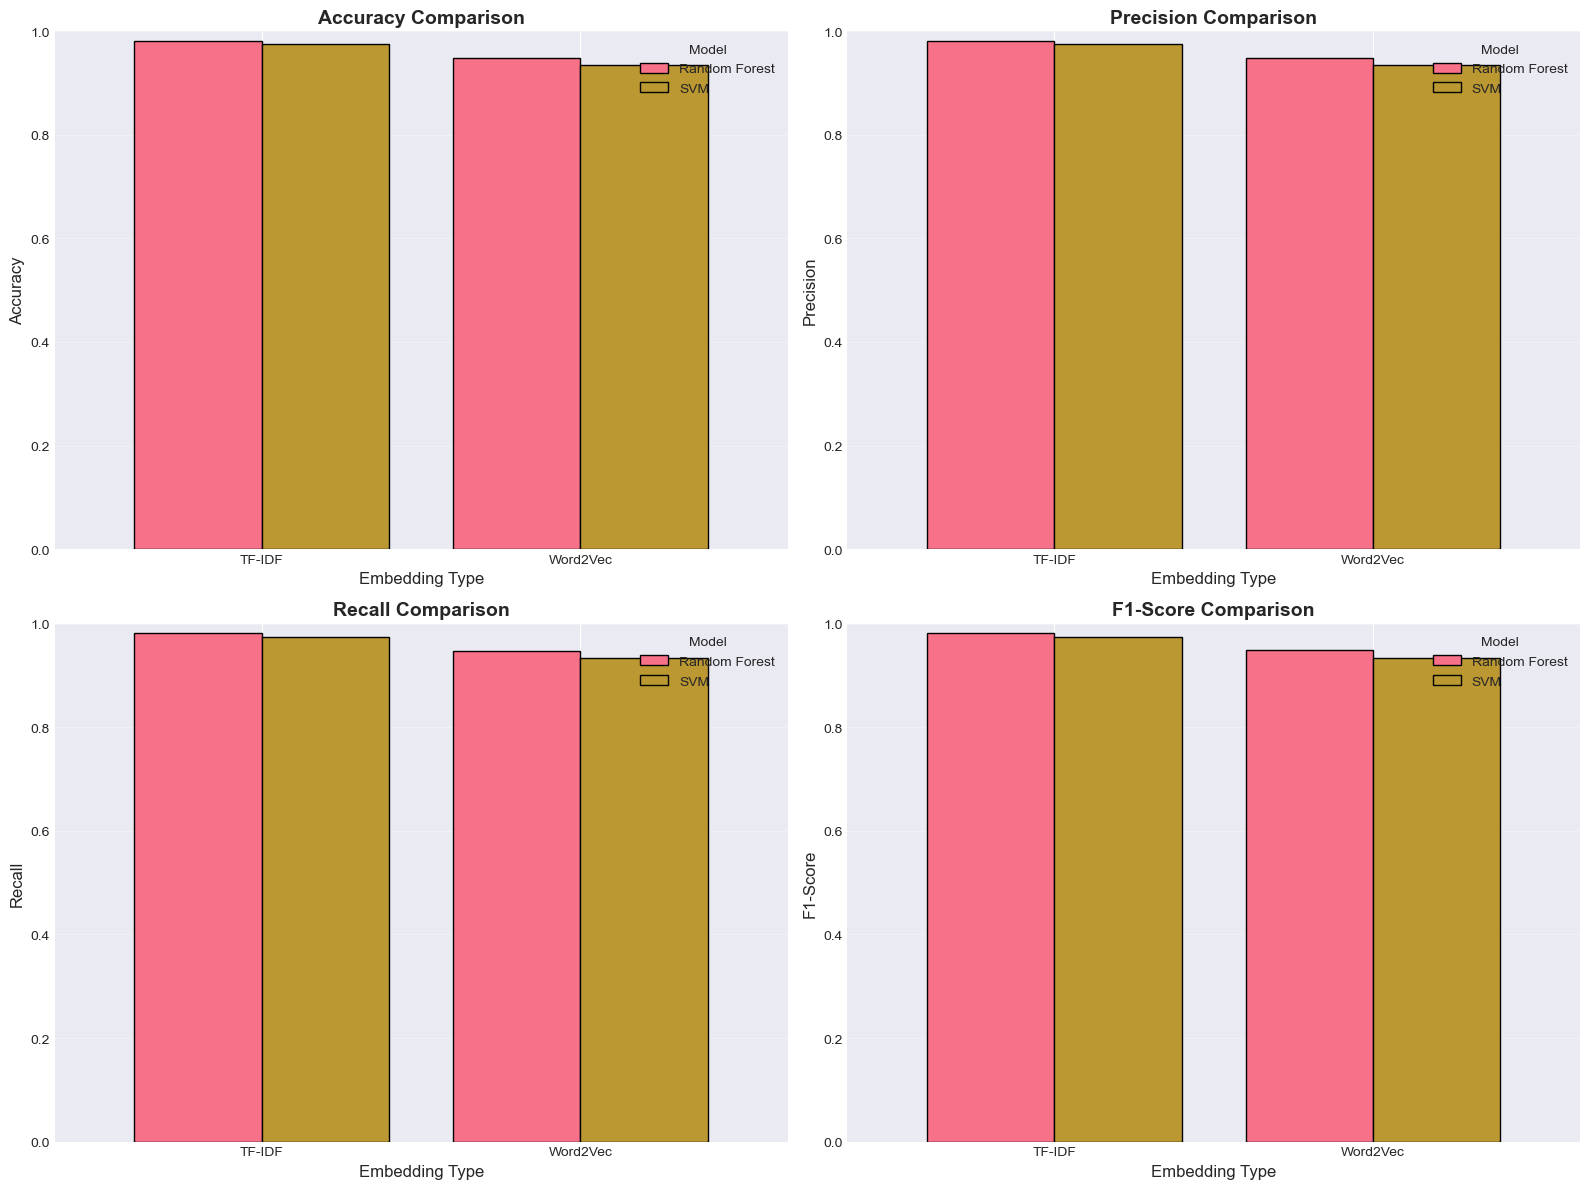

In [52]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    pivot_data = results_df.pivot(index='Embedding', columns='Model', values=metric)
    pivot_data.plot(kind='bar', ax=ax, width=0.8, edgecolor='black')
    
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xlabel('Embedding Type', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.legend(title='Model', fontsize=10)
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Generating confusion matrices for best models...



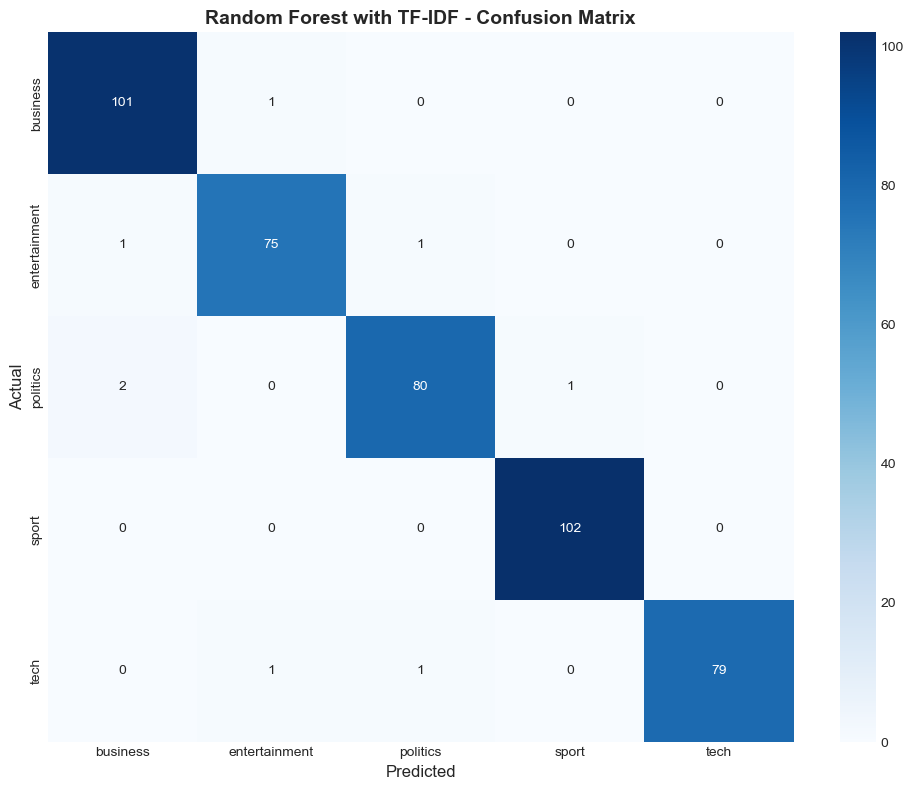

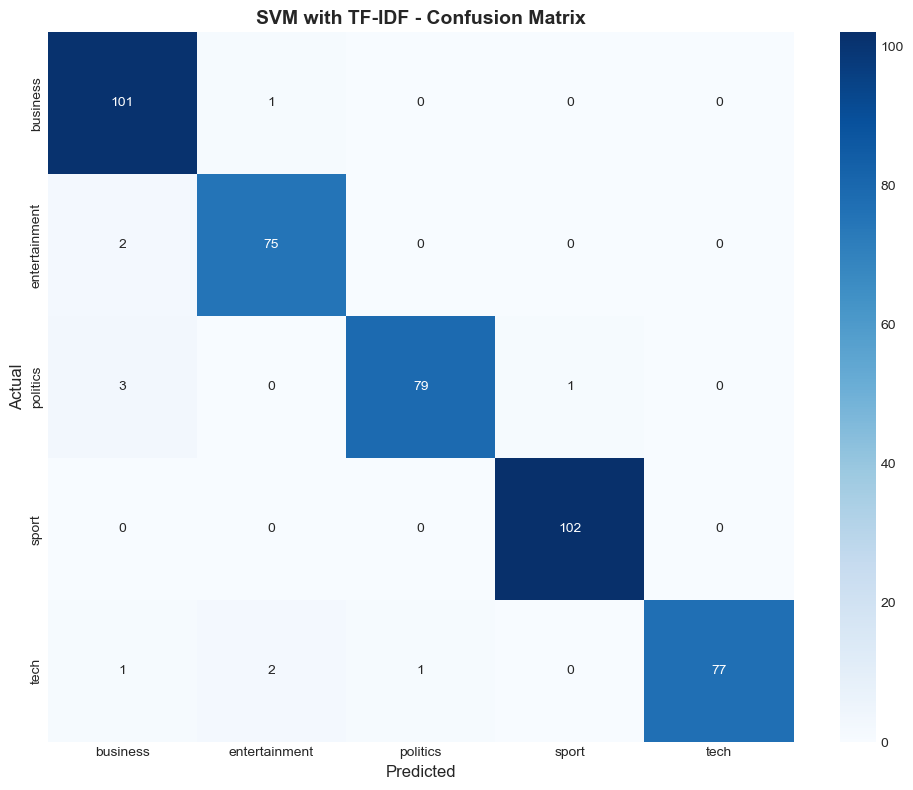

In [ ]:
# Confusion matrices for best models
def plot_confusion_matrix(y_true, y_pred, title, save_path):
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot confusion matrices for top performing models
print("\nGenerating confusion matrices for best models...\n")

# Best Random Forest model
best_rf_embedding = results_df[results_df['Model'] == 'Random Forest'].iloc[0]['Embedding']
plot_confusion_matrix(
    y_val, 
    rf_results[best_rf_embedding]['predictions'],
    f'Random Forest with {best_rf_embedding} - Confusion Matrix',
    f'results/cm_rf_{best_rf_embedding.lower().replace(" ", "_")}.png'
)

# Best SVM model
best_svm_embedding = results_df[results_df['Model'] == 'SVM'].iloc[0]['Embedding']
plot_confusion_matrix(
    y_val, 
    svm_results[best_svm_embedding]['predictions'],
    f'SVM with {best_svm_embedding} - Confusion Matrix',
    f'results/cm_svm_{best_svm_embedding.lower().replace(" ", "_")}.png'
)


Testing Best Model: Random Forest with TF-IDF

Test Accuracy: 0.9663

Test Classification Report:
               precision    recall  f1-score   support

     business       0.92      0.96      0.94       102
entertainment       0.97      1.00      0.99        77
     politics       0.97      0.90      0.94        84
        sport       1.00      0.99      1.00       102
         tech       0.96      0.97      0.97        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



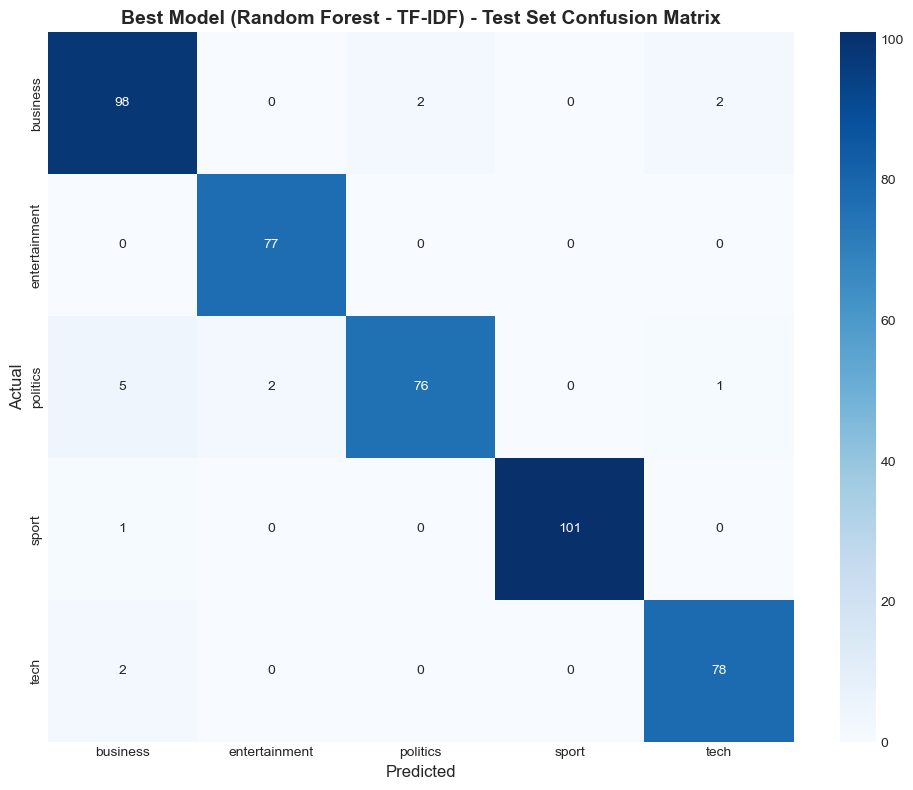

In [ ]:
# Test on best model
best_model_row = results_df.iloc[0]
best_model_name = best_model_row['Model']
best_embedding = best_model_row['Embedding']

print(f"\n{'='*60}")
print(f"Testing Best Model: {best_model_name} with {best_embedding}")
print(f"{'='*60}\n")

# Get test features
if best_embedding == 'TF-IDF':
    X_test_features = X_test_tfidf
elif best_embedding == 'GloVe':
    X_test_features = X_test_glove
else:  # FastText
    X_test_features = X_test_fasttext

# Get model
if best_model_name == 'Random Forest':
    best_model = rf_results[best_embedding]['model']
else:  # SVM
    best_model = svm_results[best_embedding]['model']

# Predict on test set
y_test_pred = best_model.predict(X_test_features)

# Evaluate
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix for test set
plot_confusion_matrix(
    y_test, 
    y_test_pred,
    f'Best Model ({best_model_name} - {best_embedding}) - Test Set Confusion Matrix',
    'results/cm_best_model_test.png'
)


## 10. Conclusion <a id='conclusion'></a>

In [ ]:
print("FINAL SUMMARY")
print("="*80)
print(f"\nTotal models trained: {len(results_df)}")
print(f"\nBest Model: {best_model_name} with {best_embedding}")
print(f"   - Validation Accuracy: {best_model_row['Accuracy']:.4f}")
print(f"   - Test Accuracy: {test_acc:.4f}")
print(f"\nAll results saved in: results/")
print(f"All models saved in: models/")


FINAL SUMMARY

Total models trained: 4

Best Model: Random Forest with TF-IDF
   - Validation Accuracy: 0.9820
   - Test Accuracy: 0.9663

All results saved in: results/
All models saved in: models/



## Key Findings:

### Embeddings Comparison:
- **TF-IDF**: Statistical approach, captures term importance
- **GloVe**: Pre-trained embeddings, captures semantic relationships
- **FastText**: Learned embeddings with subword information, robust to rare words

### Model Comparison:
- **Random Forest**: Ensemble method, handles high-dimensional data well
- **SVM**: Powerful for classification, effective with right kernel

### Next Steps:
1. Hyperparameter tuning for better performance
2. Try ensemble methods combining multiple embeddings
3. Error analysis on misclassified examples
4. Compare with team members' deep learning results (RNN, LSTM, GRU)